# Tuning the hyperparameters of Slisemap

In this notebook we will demonstrate how to automatically tune the regularisation hyperparameters of Slisemap. As the dataset we will use the *Magic Telescope* dataset.

In [3]:
import sys

import numpy as np
import pandas as pd

from pathlib import Path
from urllib.request import urlretrieve

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, "..")

from slisemap import Slisemap
from slisemap.local_models import LogisticRegression
from slisemap.tuning import optimise
from slisemap.metrics import accuracy

### Objectives

These are the objectives of this notebook:

- Describe the hyperparameters of Slisemap.
- Discuss how unseen data can be used to evaluate Slisemap.
- Demonstrate how this can be used to tune the hyperparameters.
- Discuss the symbiosis with subsampling.

## Hyperparameters

Below are the most interesting hyperparameters described in more detail:

- __local_model / local_loss__: *Prediction and loss function for the local models*. The local model must be selected to suit the data. Slisemap comes with some already implemented models: linear regression (for regression) and logistic regression (for classification).

- __lasso / ridge__: *Coefficients for Lasso/L1 regularisation and Ridge/L2 regularisation*. Since the local model are local (only fit a subset of all the data) there is a greater risk of overfitting. Therefore, it is strongly recommended to use some kind of regularisation. Slisemap comes with two common types of regularisation that can be enabled through the `lasso` and `ridge` parameters.

- __radius__: *The `radius` controls size of the embedding*. The larger the `radius` the more "independent clusters" can exist in the embedding at once. The default of $3.5$ seems to work well for many different datasets (assuming `distance=euclidean` and  `kernel=softmax` are unchanged). Only decrease/increase it if you have very little / lots of data.

- __d__: *The number of embedding dimensions*. Since most computer monitors are 2D it is very convenient to keep `d=2`.

- __intercept__: *Include an intercept term*. For linear model it is common to include an intercept term. Slisemap can automatically add a constant to column to the data (creating an intercept term in linear local models).


The choice of local model is quite subjective, so it is left for manual selection.
In this notebook we will focus on `lasso` and `ridge` because these are maybe the least intuitive of the hyperparameters.
And for the rest, such as `d` and `radius`, the default values are sufficient for most use-cases.

## Results caching

To reduce execution times, we provide pretrained Slisemap models. If you want to train them yourself instead please set `USE_CACHE=False`.

In [ ]:
USE_CACHE = True
SM_V1_CACHE_PATH = Path("cache") / "03_hyperparameter_tuning_example.v1.sm"
SM_V2_CACHE_PATH = Path("cache") / "03_hyperparameter_tuning_example.v2.sm"

for path in [SM_V1_CACHE_PATH, SM_V2_CACHE_PATH]:
    path.parent.mkdir(exist_ok=True, parents=True)
    if USE_CACHE and not path.exists():
        urlretrieve(
            f"https://raw.githubusercontent.com/edahelsinki/slisemap/data/examples/cache/{path.name}",
            path,
        )

## Data

__Magic Telescope dataset:__
The data are MC generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters.

> Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. Nucl.Instr.Meth. A, 516, pp. 511-528.

In [5]:
# Download the Magic Telescope dataset from https://www.openml.org/d/1120
data = fetch_openml(data_id=1120)
data = data.frame.dropna()
X = data.iloc[:, :-1]
scale_x = StandardScaler()
X = pd.DataFrame(scale_x.fit_transform(X), columns=X.columns)
y = pd.get_dummies(data.iloc[:, -1:])
y.columns = ["signal", "background"]

In [14]:
random_forest = RandomForestClassifier(random_state=42).fit(X.iloc[::2], y.iloc[::2])
y2 = random_forest.predict_proba(X)[1]
print("Correctly classified:", np.mean(np.argmax(y.to_numpy(), 1)[1::2] == np.argmax(y2, 1)[1::2]))

Correctly classified: 0.8802313354363828


## Slisemap

We subsample 2000 data items for training, 2000 for testing, and the rest as validation data.

In [7]:
# Subsample the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y2, train_size=2000, stratify=y.iloc[:, 0], random_state=42
)
X_test, X_validation, y_test, y_validation = train_test_split(
    X_test, y_test, train_size=2000, stratify=y_test[:, 0] > 0.5, random_state=42
)

Now we create a Slisemap object and optimise the solution.
Since we are dealing with a classification task we replace the default white box model with logistic regression.

In [8]:
if not USE_CACHE or not SM_V1_CACHE_PATH.exists():
    # Create a Slisemap object with lasso regularisation
    sm = Slisemap(
        X_train,
        y_train,
        lasso=0.001,
        ridge=0.001,
        intercept=False,
        local_model=LogisticRegression,
        random_state=42,
    )
    # Optimise the solution
    sm.optimise()
    # Metadata
    # sm.metadata.set_variables(names)
    sm.metadata.set_targets(y.columns)
    sm.metadata.set_scale_X(scale_x.mean_, scale_x.scale_)
    # Cache the results
    sm.save(SM_V1_CACHE_PATH)
else:
    sm = Slisemap.load(SM_V1_CACHE_PATH, device="cpu")

Here we guessed that `lasso=0.001` and `ridge=0.001` would be good values. But how can we check if this is actually true?

## Evaluation using validation data

To measure how well the Slisemap solution generalises to unseen data we can use the `accuracy` function from `slisemap.metrics`.
This function finds a local model for each unseen data item (using `Slisemap.fit_new` to copy an existing local model) and then calculates the local losses:

In [9]:
from slisemap.metrics import accuracy

acc1 = accuracy(sm, X_validation, y_validation)
print(f"Accuracy (without tuning): {acc1:.5f}")

Accuracy (without tuning): 0.00563


## Hyperparameter optimisation

This "accyracy" value can be used to automatically tune the hyperparameters, for example using `RandomizedSearchCV` from `sklearn.model_selection`. However, optimising many Slisemap solutions from scratch can be quite a time-consuming process. A faster solution is to use the hyperparameter tuning procedures that comes with Slisemap.

In [10]:
from slisemap.tuning import optimise

if not USE_CACHE or not SM_V2_CACHE_PATH.exists():
    sm2 = sm.copy()
    sm2.restore()
    # Optimise Slisemap with hyperparameter tuning
    sm2 = optimise(sm2, X_test, y_test)
    # Cache the results
    sm2.save(SM_V2_CACHE_PATH)
else:
    sm2 = Slisemap.load(SM_V2_CACHE_PATH, device="cpu")

This procedure is similar to the normal Slisemap optimisation, but after each LBFGS round a small local search is performed for tuning `lasso` and `ridge`. The local search is less exhaustive than a "normal" hyperprameter optimisation, but should be significantly faster.

In [11]:
print(f"Tuned hyperparameters: lasso = {sm2.lasso:.5f}, ridge = {sm2.ridge:.5f}")
acc2 = accuracy(sm2, X_validation, y_validation)

Tuned hyperparameters: lasso = 0.00004, ridge = 0.00004


The `slisemap.tuning.optimise` function can also be called without test data (`X_test` `y_test`), in which case a (slower) cross validation procedure is used instead.

## Comparison

With the tuned hyperparameters we are able to half the "accuracy" metric. However, the losses and accuracy are already quite good before the tuning (for this dataset with 2000 training items):

In [12]:
print("Accuracy (without tuning), Training:  ", accuracy(sm, X_train, y_train))
print("Accuracy (without tuning), Testing:   ", accuracy(sm, X_test, y_test))
print("Accuracy (without tuning), Validation:", accuracy(sm, X_validation, y_validation))
print("Accuracy (after tuning), Training:    ", accuracy(sm2, X_train, y_train))
print("Accuracy (after tuning), Testing:     ", accuracy(sm2, X_test, y_test))
print("Accuracy (after tuning), Validation:  ", accuracy(sm2, X_validation, y_validation))

Accuracy (without tuning), Training:   0.005181449465453625
Accuracy (without tuning), Testing:    0.00558066088706255
Accuracy (without tuning), Validation: 0.005628352984786034
Accuracy (after tuning), Training:     0.0025088235270231962
Accuracy (after tuning), Testing:      0.0027896573301404715
Accuracy (after tuning), Validation:   0.0027210544794797897


Furthermore, a common use-case for Slisemap is visualisation and exploratory data analysis. Therefore, the choice of hyperparameter is also subjective, the visualisations need to suit the users preferences, not only match the random forest predictions. For example, increasing `lasso` tends to make the local models more sparse, which makes the interpretation easier. The difference in sparsity can be seen when plotting the two solutions:

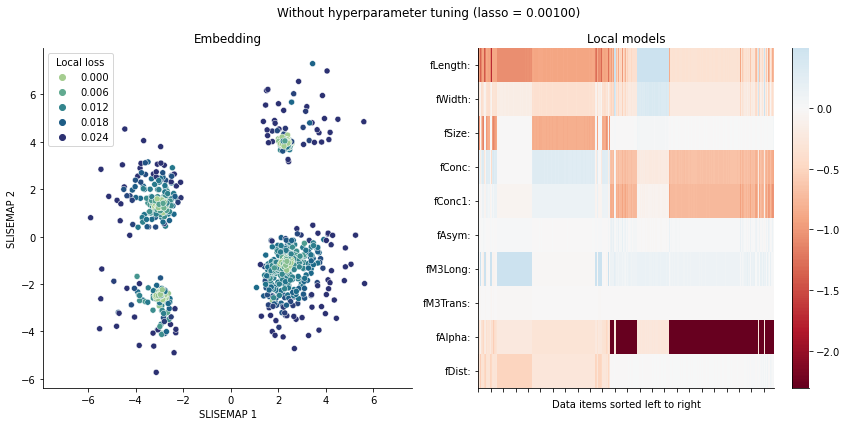

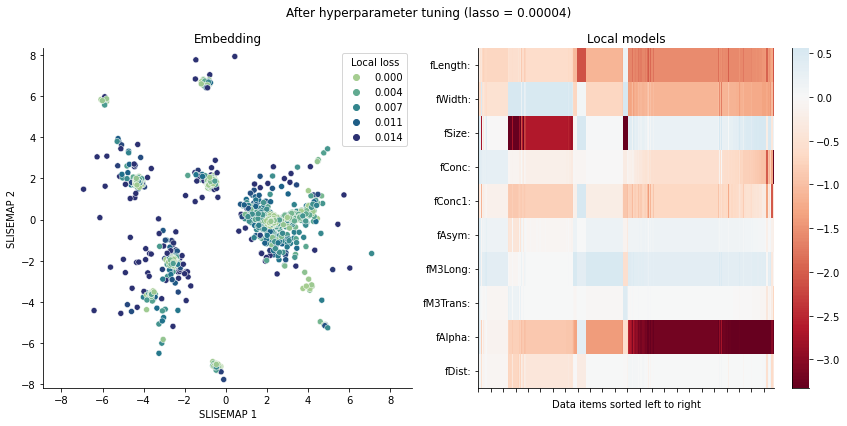

In [13]:
sm.plot(title=f"Without hyperparameter tuning (lasso = {sm.lasso:.5f})", jitter=0.1)
sm2.plot(title=f"After hyperparameter tuning (lasso = {sm2.lasso:.5f})", jitter=0.1)

Thus, the tuned hyperparameters can be seen as a "baseline" or lower bound for manual tweaking (if necessary). As is demonstrated in the previous example notebook, when tweaking hyperparameters it is possible to continue the optimisation from a previous solution (instead of starting from scratch).

## Conclusions

The use of subsampling with Slisemap is mainly motivated by:

1. The visualisations are limited by the number of pixels, thus there is a limit where adding more data has a very marginal value.
2. Due to the square distance matrix, Slisemap becomes quite slow with large datasets.

In this notebook we demonstrate how the additional data (not in the subsample) can be used to improve the results through hyperparameter tuning. Regularisation is most useful when the number of variables is large or the number of data items small (unlike the dataset used for this example). The hyperparameter optimisation procedure that comes with Slisemap is designed for speed through the use of (less exhaustive) local search. The objective, used for the tuning, is to find a Slisemap solution that best suits unseen data, not a Slisemap solution with the best visualisation. Therefore, manual tweaking can still be adventageous (with the automatically tuned values as a starting point).